In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
tqdm.monitor_interval = 0
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
FORECAST = 5
EPS = 120
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [13]:
dset = LocalRoute(SROUTE, 'train', 32).generator()
evalset = LocalRoute(SROUTE, 'test', 32).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.52s)
 [*] Has trainable inds: 3480
 [*] Subset train: 2808
Locals dataset: test
 [*] Loaded routes: 1 (0.33s)
 [*] Has trainable inds: 3480
 [*] Subset test: 672


In [9]:
from models.Conv import Conv

In [10]:
model = Conv(forecast=FORECAST, hidden_size=256).to(device)
model.device = device

In [11]:
criterion, opt, sch = model.params(lr=0.001)
sch = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.5)

In [14]:
evaluate(evalset, model, criterion)

Eval loss: 20.122530755542574


In [15]:
losses = []
eval_losses = []
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_losses.append(evaluate(evalset, model, criterion, result=True))
    sys.stdout.flush()
    sch.step()

[1/120 : 88/88] - L17.79      
Eval loss: 15.703920228140694
[2/120 : 88/88] - L2.82       
Eval loss: 7.685354732331776
[3/120 : 88/88] - L5.46       
Eval loss: 7.390157273837498
[4/120 : 88/88] - L6.93       
Eval loss: 7.260081427437918
[5/120 : 88/88] - L2.15       
Eval loss: 7.157935664767311
[6/120 : 88/88] - L2.48       
Eval loss: 7.0663621085030695
[7/120 : 88/88] - L5.18       
Eval loss: 6.98628678775969
[8/120 : 88/88] - L1.48       
Eval loss: 6.928507697014582
[9/120 : 88/88] - L6.19       
Eval loss: 6.848083524476914
[10/120 : 88/88] - L3.25       
Eval loss: 6.7892766282671975
[11/120 : 88/88] - L2.32       
Eval loss: 6.740916581380935
[12/120 : 88/88] - L2.10       
Eval loss: 6.691069012596493
[13/120 : 88/88] - L1.78       
Eval loss: 6.669755736986796
[14/120 : 88/88] - L5.27       
Eval loss: 6.629518469174703
[15/120 : 88/88] - L8.30       
Eval loss: 6.602757101967221
[16/120 : 88/88] - L2.15       
Eval loss: 6.585090563410804
[17/120 : 88/88] - L5.68       

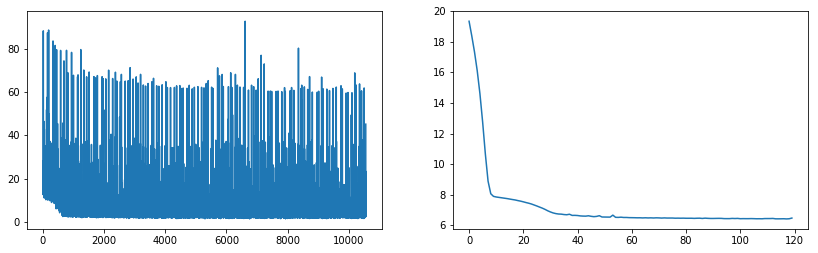

In [10]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.subplot(1, 2, 2)
plt.plot(eval_losses)
plt.show();plt.close()

6


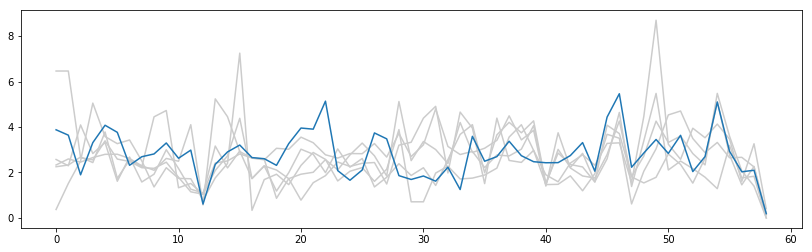

In [11]:
data = history_byname(SROUTE)

sample = data[int(TSTEPS*0.8):]
inds, integs = high_integ(sample[6:])
inds += 6
print(inds[0])
sample = sample[inds[0]-6:inds[0]]
show_context(sample)

In [12]:
preds = []
for bi in range(10, sample.shape[1]+1):
    hist = sample[:, bi-10:bi].T
    Xs = np.expand_dims(hist, 1)
    Xs = torch.from_numpy(Xs).to(device).float()
    seqs = list(map(lambda vec: vec.squeeze(0), torch.split(Xs, 1)))
    seqs = list(reversed(seqs))

    yout = model(seqs)
    preds.append(tonpy(yout))

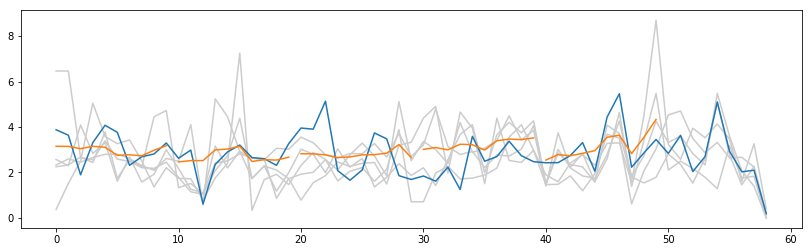

In [13]:
show_context(sample, draw=False)
for bi in range(10, sample.shape[1]+1, 10):
    ylast = np.flip(preds[bi-10][:, 0, -1])
    xpos = list(range(bi-10, bi))
    plt.plot(xpos, ylast, color='C1')
plt.show(); plt.close()